In [26]:
!nvidia-smi

Sat Feb 22 10:57:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              3W /   70W |    3933MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
import os

# Check if the file already exists
file_path = "C:/Users/darsh/OneDrive/Desktop/ai-recipe-generator-image-ingrediants/eval/content/test-5000.csv"

In [28]:
%%capture
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git

In [29]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [30]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import os
import json
import re
import textwrap

import torch
import torch.nn.functional as F
from datasets import load_dataset, load

from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

In [32]:

model_name_or_path = "mbien/recipenlg"

# Force execution on CPU
device = torch.device("cpu")
print(model_name_or_path, device)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

# Load model on CPU
model = AutoModelForCausalLM.from_pretrained(model_name_or_path).to(device)


mbien/recipenlg cpu


In [33]:
dataset = load_dataset("csv", data_files={"test": "../eval/content/test-5000.csv"}, delimiter="\t")["test"]
dataset

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 5000
})

In [34]:
tokenizer("<RECIPE_START>")

genkw = {
    "max_length": 512,
    "min_length": 64,
    "no_repeat_ngram_size": 3,
    "do_sample": True,
    "top_k": 60,
    "top_p": 0.95,
    "num_return_sequences": 5
}

In [35]:
def post_processing(text):
    r_s, r_e = "<RECIPE_START>", "<RECIPE_END>"
    t_s, t_e = "<TITLE_START>", "<TITLE_END>"
    i_s, i_e = "<INGR_START>", "<INGR_END>"
    d_s, d_e = "<INSTR_START>", "<INSTR_END>"

    if not r_s in text or not r_e in text:
        return None
    
    text = text[text.find(r_s) + len(r_s): text.find(r_e)]

    if not t_s in text or not i_s in text or not d_s in text:
        return None
    
    if not t_e in text or not i_e in text or not d_e in text:
        return None

    title = text[text.find(t_s) + len(t_s): text.find(t_e)]
    ingredients = text[text.find(i_s) + len(i_s): text.find(i_e)].replace("<NEXT_INGR>", " ")
    directions = text[text.find(d_s) + len(d_s): text.find(d_e)].replace("<NEXT_INSTR>", " ")

    if not len(title) > 0 or not len(ingredients) > 0 or not len(directions) > 0:
        return None

    title = [w.strip() for w in title.split() if w.strip()]
    ingredients = [w.strip() for w in ingredients.split() if w.strip()]
    directions = [w.strip() for w in directions.split() if w.strip()]

    title = ' '.join(title).lower()
    ingredients = ' '.join(ingredients).lower()
    directions = ' '.join(directions).lower()

    return f"title: {title} ingredients: {ingredients} directions: {directions}"


def post_processing_list(texts):
    new_texts = []
    
    for text in texts:
        text = post_processing(text)
        if text:
            new_texts.append(text)
    
    return new_texts

def predict(batch):
    inputs = [
        '<RECIPE_START> <INPUT_START> ' + inp.replace(', ', ' <NEXT_INPUT> ') + ' <INPUT_END>'
        for inp in batch["inputs"]
    ]
    
    inputs = tokenizer(
        inputs, 
        max_length=256, 
        padding=True, 
        truncation=True, 
        return_tensors='pt'
    )
    input_ids = inputs.input_ids.to(device)
    # attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids, 
            # attention_mask=attention_mask,
            **genkw
        )

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    batch["predicted"] = [post_processing_list(outputs[i:i + genkw["num_return_sequences"]]) for i in range(0, len(outputs), genkw["num_return_sequences"])]
    return batch

In [36]:
# OR You can pass this step
# !wget -c "https://raw.githubusercontent.com/chef-transformer/chef-transformer/main/data/RecipNLG_predicted.json" /content/predicted.json

In [37]:
sample = dataset.select(range(1))
result = dataset.map(predict, batched=True, batch_size=8)
result

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` t

Dataset({
    features: ['inputs', 'targets', 'predicted'],
    num_rows: 5000
})

In [39]:
df_list = []
for i in tqdm(range(len(result)), position=0):
    inputs, targets, predicted =  result["inputs"][i], result["targets"][i], result["predicted"][i]
    df_list.append({
        "input": inputs,
        "target": targets,
        "predicted": predicted,
    })

df = pd.DataFrame(df_list)
df.to_json("../eval/content1/predicted.json")
df.head()

100%|██████████| 5000/5000 [02:42<00:00, 30.68it/s]


,input,target,predicted
0,"margarine, sugar, eggs, sour cream, vanilla, c...",title: sour cream coffee cake ingredients: 1 c...,[title: easy easy fruit upside down cake ingre...
1,"peanut oil, brown onions, curry powder, cardam...",title: curried spinach onion rice ingredients:...,[title: green rice with spinach ingredients: 1...
2,"ground chuck, long shuttle noodles, spaghetti ...",title: cavatini casserole ingredients: 2 lb. g...,[title: grandma's cheeseburger bake ingredient...
3,"dates, boiling water, baking mix, sugar, eggs,...",title: quick date nut bread ingredients: 1 1/2...,[title: macadamia nuts cake ingredients: 1/2 c...
4,"lemon juice, peaches, graham cracker pie crust",title: peach cream pie ingredients: 1 14 oz. c...,[title: grandma's peach pie ingredients: 3 tbs...


In [42]:
df = pd.read_json("../eval/content1/predicted.json")
print(df.shape)
df["predicted"] = df["predicted"].apply(lambda t: t if len(t) > 0 else None)
df = df.dropna()
df = df.reset_index(drop=True) 
print(df.shape)
df.head()

(5000, 3)
(4037, 3)


,input,target,predicted
0,"margarine, sugar, eggs, sour cream, vanilla, c...",title: sour cream coffee cake ingredients: 1 c...,[title: easy easy fruit upside down cake ingre...
1,"peanut oil, brown onions, curry powder, cardam...",title: curried spinach onion rice ingredients:...,[title: green rice with spinach ingredients: 1...
2,"ground chuck, long shuttle noodles, spaghetti ...",title: cavatini casserole ingredients: 2 lb. g...,[title: grandma's cheeseburger bake ingredient...
3,"dates, boiling water, baking mix, sugar, eggs,...",title: quick date nut bread ingredients: 1 1/2...,[title: macadamia nuts cake ingredients: 1/2 c...
4,"lemon juice, peaches, graham cracker pie crust",title: peach cream pie ingredients: 1 14 oz. c...,[title: grandma's peach pie ingredients: 3 tbs...


In [ ]:
!pip freeze | grep nltk

nltk==3.6.2


In [ ]:
%%capture
!pip install -U nltk
!pip install jiwer
!pip install rouge_score

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

import re
import math
from collections import Counter
import string
from tqdm import tqdm

In [44]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
        
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def get_result(content_a, content_b):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine_result = get_cosine(vector1, vector2)
    return cosine_result

In [46]:
cosim_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted_list = row["target"], row["predicted"]

    target = " ".join([word.strip() for word in wordpunct_tokenize(target) if word not in string.punctuation and word not in stopwords and word])

    cosim_score = []
    for j in range(len(predicted_list)):
        predicted = " ".join([word.strip() for word in wordpunct_tokenize(predicted_list[j]) if word not in string.punctuation and word not in stopwords and word])
        cosim_score.append(get_result(target, predicted))

    cosim_scores.append(max(cosim_score))
    # break

  0%|          | 0/4037 [00:00<?, ?it/s]

100%|██████████| 4037/4037 [00:06<00:00, 664.85it/s]


In [47]:
cosim_score = np.array(cosim_scores).mean()
print(f"Cosine similarity score: {cosim_score}")

Cosine similarity score: 0.5932923837696517


In [51]:
from jiwer import wer
wer_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted_list = row["target"], row["predicted"]

    wer_score = []
    for j in range(len(predicted_list)):
        score = wer(target, predicted_list[j])
        wer_score.append(score)

    wer_scores.append(min(wer_score))

    # break

100%|██████████| 4037/4037 [00:01<00:00, 2191.47it/s]


In [52]:
wer_score = np.array(wer_scores).mean()
print(f"WER score: {wer_score}")

WER score: 1.2265493684784812


In [63]:

from evaluate import load

rouge = load("rouge")
rouge_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predictions = row["target"], row["predicted"]

    references = [target] * len(predictions)
    score = rouge.compute(references=references, predictions=predictions, use_stemmer=True)
    if isinstance(score["rouge2"], dict) and "fmeasure" in score["rouge2"]:
        rouge2 = score["rouge2"]["fmeasure"]
    else:
        rouge2 = score["rouge2"]
    rouge_scores.append(rouge2)

100%|██████████| 4037/4037 [09:17<00:00,  7.24it/s]


In [65]:
rouge_score = np.array(rouge_scores).mean()
print(f"Rouge score: {rouge_score}") 

Rouge score: 0.11148423343022619


In [66]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

import nltk.translate.gleu_score as gleu
import nltk.translate.meteor_score as meteor


def compute_bleu(recipe, refer):
    hyp = recipe
    refs = refer
    smoothie = SmoothingFunction().method4
    score_ref_a = bleu.sentence_bleu(refs, hyp, smoothing_function=smoothie)
    return score_ref_a


def compute_gleu(recipe, refer):
    hyp = recipe
    refs = refer
    score_ref_a = gleu.sentence_gleu(refs, hyp)
    return score_ref_a

def compute_meteor(recipe, refer):
    hyp = recipe
    refs = refer
    score_ref_a = meteor.meteor_score(refs, hyp)
    return score_ref_a

In [67]:
bleu_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted = row["target"], row["predicted"]

    target = wordpunct_tokenize(target)
    predicted = [wordpunct_tokenize(p) for p in predicted]

    score = compute_bleu(target, predicted)
    bleu_scores.append(score)

    # break

100%|██████████| 4037/4037 [00:06<00:00, 603.33it/s]


In [68]:
bleu_score = np.array(bleu_scores).mean()
print(f"BLEU score: {bleu_score}")

BLEU score: 0.10903898871249999


In [69]:
gleu_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted = row["target"], row["predicted"]

    target = wordpunct_tokenize(target)
    predicted = [wordpunct_tokenize(p) for p in predicted]

    score = compute_gleu(target, predicted)
    gleu_scores.append(score)

    # break

100%|██████████| 4037/4037 [00:05<00:00, 699.46it/s]


In [70]:
gleu_score = np.array(gleu_scores).mean()
print(f"GLEU score: {gleu_score}")

GLEU score: 0.14706079767223018


In [72]:
m_scores = []
for index, row in tqdm(df.iterrows(), total=len(df), position=0):
    target, predicted_list = row["target"], row["predicted"]

    target_tokens = wordpunct_tokenize(target)
    predicted_tokens_list = [wordpunct_tokenize(p) for p in predicted_list]

    score = compute_meteor(target_tokens, predicted_tokens_list)
    m_scores.append(score)

    # break

100%|██████████| 4037/4037 [00:51<00:00, 79.11it/s] 


In [73]:
m_score = np.array(m_scores).mean()
print(f"METEOR score: {m_score}")

METEOR score: 0.2914746982050875


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer


In [88]:

# Calculate BLEU score
def calculate_bleu(references, predictions):
    # Tokenize the references and predictions
    references = [[ref.split()] for ref in references]
    predictions = [pred.split() for pred in predictions]
    return corpus_bleu(references, predictions)

In [89]:

# Calculate ROUGE scores
def calculate_rouge(references, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = []
    for ref, pred in zip(references, predictions):
        score = scorer.score(ref, pred)
        scores.append(score)
    return scores

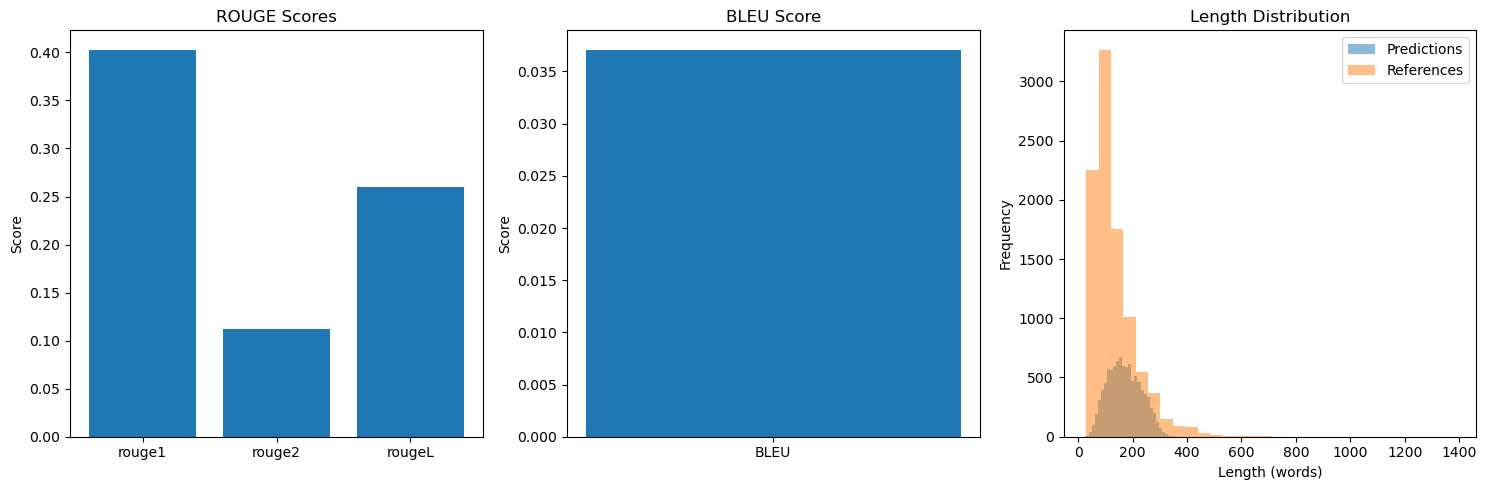


Detailed Metrics:
BLEU Score: 0.0371

Average ROUGE Scores:
rouge1: 0.4028
rouge2: 0.1126
rougeL: 0.2599


In [90]:



# Flatten the predicted lists
flattened_predicted = []
flattened_target = []
for preds, target in zip(df['predicted'], df['target']):
    for pred in preds:
        flattened_predicted.append(pred)
        flattened_target.append(target)

# Calculate metrics
bleu_score = calculate_bleu(flattened_target, flattened_predicted)
rouge_scores = calculate_rouge(flattened_target, flattened_predicted)

# Calculate average ROUGE scores
avg_rouge_scores = {
    'rouge1': np.mean([s['rouge1'].fmeasure for s in rouge_scores]),
    'rouge2': np.mean([s['rouge2'].fmeasure for s in rouge_scores]),
    'rougeL': np.mean([s['rougeL'].fmeasure for s in rouge_scores])
}

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: ROUGE Scores
plt.subplot(131)
plt.bar(avg_rouge_scores.keys(), avg_rouge_scores.values())
plt.title('ROUGE Scores')
plt.ylabel('Score')

# Plot 2: BLEU Score
plt.subplot(132)
plt.bar(['BLEU'], [bleu_score])
plt.title('BLEU Score')
plt.ylabel('Score')

# Plot 3: Length Distribution
plt.subplot(133)
pred_lengths = [len(pred.split()) for pred in flattened_predicted]
ref_lengths = [len(ref.split()) for ref in flattened_target]
plt.hist(pred_lengths, alpha=0.5, label='Predictions', bins=30)
plt.hist(ref_lengths, alpha=0.5, label='References', bins=30)
plt.title('Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics:")
print(f"BLEU Score: {bleu_score:.4f}")
print("\nAverage ROUGE Scores:")
for metric, score in avg_rouge_scores.items():
    print(f"{metric}: {score:.4f}")

C:\Users\darsh\AppData\Local\Temp\ipykernel_5180\64851657.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pred_lengths, ref_lengths], labels=['Predictions', 'References'])


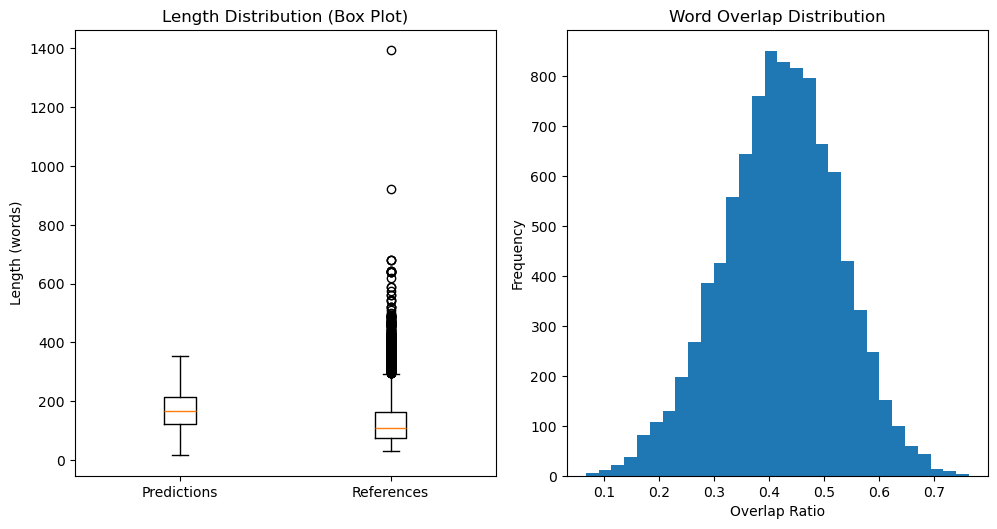

In [93]:
# Add more evaluation metrics
plt.figure(figsize=(15, 10))

# Original three plots
# ...existing code...

# Add new plots for more detailed analysis
plt.subplot(234)
plt.boxplot([pred_lengths, ref_lengths], labels=['Predictions', 'References'])
plt.title('Length Distribution (Box Plot)')
plt.ylabel('Length (words)')

plt.subplot(235)
# Calculate and plot word overlap
word_overlap = [len(set(pred.split()) & set(ref.split())) / len(set(ref.split()))
                for pred, ref in zip(flattened_predicted, flattened_target)]
plt.hist(word_overlap, bins=30)
plt.title('Word Overlap Distribution')
plt.xlabel('Overlap Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

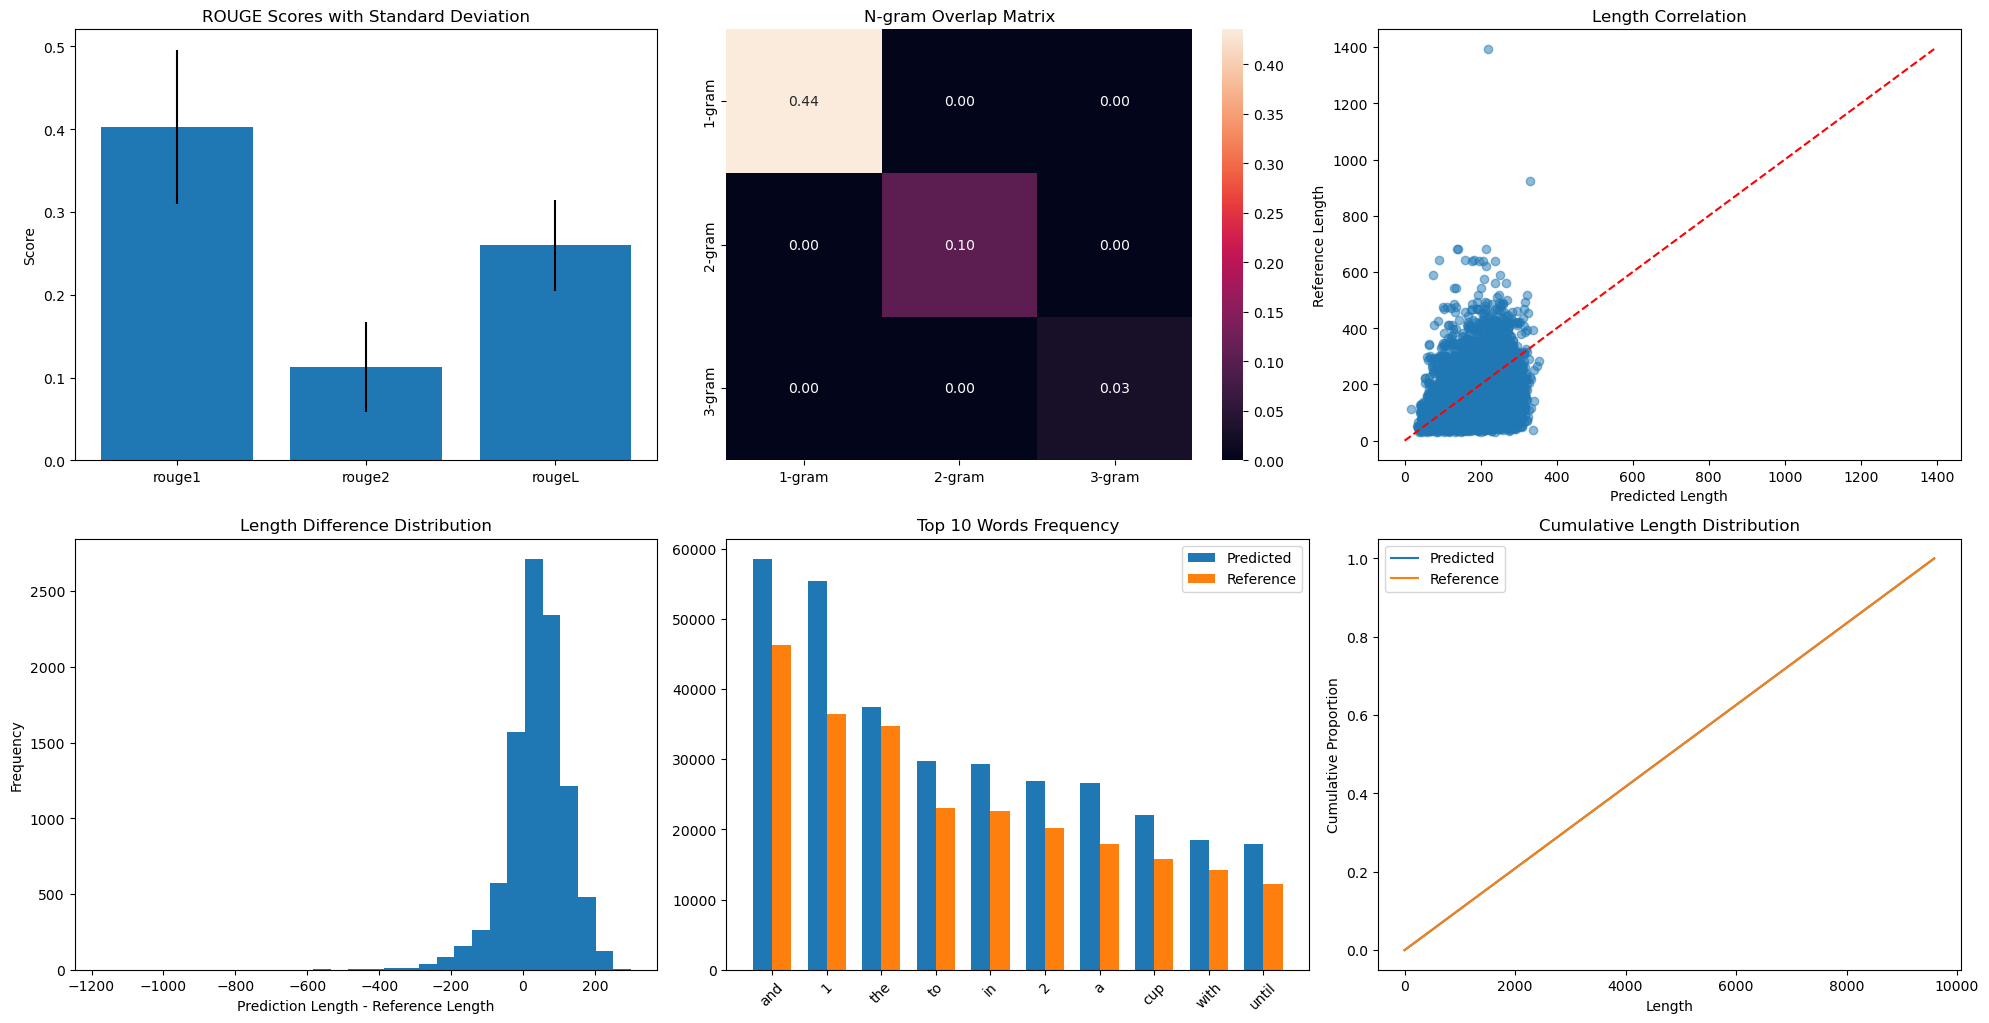


Additional Statistics:
Average prediction length: 170.50
Average reference length: 132.20
Length correlation coefficient: 0.33


In [94]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Create a larger figure for multiple plots
plt.figure(figsize=(20, 15))

# 1. Original ROUGE Scores (enhanced with error bars)
plt.subplot(331)
rouge_std = {
    'rouge1': np.std([s['rouge1'].fmeasure for s in rouge_scores]),
    'rouge2': np.std([s['rouge2'].fmeasure for s in rouge_scores]),
    'rougeL': np.std([s['rouge2'].fmeasure for s in rouge_scores])
}
plt.bar(avg_rouge_scores.keys(), avg_rouge_scores.values(), yerr=list(rouge_std.values()))
plt.title('ROUGE Scores with Standard Deviation')
plt.ylabel('Score')

# 2. N-gram Overlap Heatmap
plt.subplot(332)
def get_ngrams(text, n):
    words = text.split()
    return set(' '.join(words[i:i+n]) for i in range(len(words)-n+1))

ngram_overlap = np.zeros((3,3))
for pred, ref in zip(flattened_predicted[:100], flattened_target[:100]):  # Sample first 100 for speed
    for i in range(3):
        for j in range(3):
            pred_ngrams = get_ngrams(pred, i+1)
            ref_ngrams = get_ngrams(ref, j+1)
            overlap = len(pred_ngrams & ref_ngrams) / len(ref_ngrams) if ref_ngrams else 0
            ngram_overlap[i,j] += overlap
ngram_overlap /= 100

sns.heatmap(ngram_overlap, annot=True, fmt='.2f', 
            xticklabels=['1-gram', '2-gram', '3-gram'],
            yticklabels=['1-gram', '2-gram', '3-gram'])
plt.title('N-gram Overlap Matrix')

# 3. Sentence Length Correlation
plt.subplot(333)
plt.scatter(pred_lengths, ref_lengths, alpha=0.5)
plt.plot([0, max(max(pred_lengths), max(ref_lengths))], 
         [0, max(max(pred_lengths), max(ref_lengths))], 
         'r--')
plt.xlabel('Predicted Length')
plt.ylabel('Reference Length')
plt.title('Length Correlation')

# 4. Length Difference Distribution
plt.subplot(334)
length_diffs = [p - r for p, r in zip(pred_lengths, ref_lengths)]
plt.hist(length_diffs, bins=30)
plt.title('Length Difference Distribution')
plt.xlabel('Prediction Length - Reference Length')
plt.ylabel('Frequency')

# 5. Word Frequency Comparison (Top 10 words)
plt.subplot(335)
from collections import Counter
def get_top_words(texts, n=10):
    words = [word for text in texts for word in text.lower().split()]
    return dict(Counter(words).most_common(n))

pred_words = get_top_words(flattened_predicted)
ref_words = get_top_words(flattened_target)

x = np.arange(10)
width = 0.35
plt.bar(x - width/2, list(pred_words.values()), width, label='Predicted')
plt.bar(x + width/2, list(ref_words.values()), width, label='Reference')
plt.xticks(x, list(pred_words.keys()), rotation=45)
plt.title('Top 10 Words Frequency')
plt.legend()

# 6. Cumulative Length Distribution
plt.subplot(336)
pred_lengths_sorted = sorted(pred_lengths)
ref_lengths_sorted = sorted(ref_lengths)
plt.plot(range(len(pred_lengths_sorted)), 
         [x/len(pred_lengths_sorted) for x in range(len(pred_lengths_sorted))],
         label='Predicted')
plt.plot(range(len(ref_lengths_sorted)), 
         [x/len(ref_lengths_sorted) for x in range(len(ref_lengths_sorted))],
         label='Reference')
plt.title('Cumulative Length Distribution')
plt.xlabel('Length')
plt.ylabel('Cumulative Proportion')
plt.legend()

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nAdditional Statistics:")
print(f"Average prediction length: {np.mean(pred_lengths):.2f}")
print(f"Average reference length: {np.mean(ref_lengths):.2f}")
print(f"Length correlation coefficient: {np.corrcoef(pred_lengths, ref_lengths)[0,1]:.2f}")

In [127]:
import os
import json
from colorama import Fore, Style

# Define the all_metrics dictionary
all_metrics = {
    "cosine_similarity": cosim_score,
    "rouge": rouge_score,
    "bleu": bleu_score,
    "gleu": gleu_score,
    "meteor": m_score
}

# Save all metrics to a file
output_dir = "output_chef_RecipeNLG"
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "metrics.json"), "w") as f:
    json.dump(all_metrics, f, indent=2)
print(f"{Fore.GREEN}✓{Style.RESET_ALL} Metrics saved to {os.path.join(output_dir, 'metrics.json')}")

# Define the print_section function
def print_section(title):
    print(f"\n{'='*len(title)}\n{title}\n{'='*len(title)}\n")

# Define the ascii_bar_chart function
def ascii_bar_chart(values, labels, title):
    max_len = max(len(label) for label in labels)
    max_value = max(values)
    scale = 50 / max_value
    print(f"\n{title}\n")
    for label, value in zip(labels, values):
        bar = '#' * int(value * scale)
        print(f"{label.ljust(max_len)} | {bar} {value:.2f}")

# Visualization: ASCII bar chart of metrics
print_section("Metric Visualizations")

# Bar chart for all metrics
metric_names = ["Cosine Sim", "ROUGE", "BLEU", "GLEU", "METEOR"]
metric_values = [all_metrics["cosine_similarity"], all_metrics["rouge"], 
                 all_metrics["bleu"], all_metrics["gleu"], all_metrics["meteor"]]

ascii_bar_chart(metric_values, metric_names, "Comparison of Metrics (higher is better)")


✓ Metrics saved to output_chef_RecipeNLG\metrics.json

Metric Visualizations


Comparison of Metrics (higher is better)

Cosine Sim | ################################################## 0.59
ROUGE      | ######### 0.11
BLEU       | ### 0.04
GLEU       | ############ 0.15
METEOR     | ######################## 0.29


In [128]:
# Distribution charts for each metric (using histogram)
for metric_name, scores in [
    ("Cosine Similarity", cosim_scores),
    ("WER", wer_scores),
    ("ROUGE", [score['rouge2'].fmeasure if isinstance(score['rouge2'], dict) else score['rouge2'] for score in rouge_scores]),
    ("BLEU", bleu_scores),
    ("GLEU", gleu_scores),
    ("METEOR", m_scores)
]:
    print(f"\n{Fore.CYAN}Distribution of {metric_name} scores:{Style.RESET_ALL}")
    
    # Calculate histogram data
    hist, bin_edges = np.histogram(scores, bins=10)
    
    # Print ASCII histogram
    max_count = max(hist)
    for i in range(len(hist)):
        bar_length = int((hist[i] / max_count) * 30)
        print(f"{bin_edges[i]:.3f} - {bin_edges[i+1]:.3f} | {'█' * bar_length} {hist[i]}")



Distribution of Cosine Similarity scores:
0.090 - 0.168 |  2
0.168 - 0.246 |  8
0.246 - 0.325 | ██ 76
0.325 - 0.403 | ████ 180
0.403 - 0.482 | ██████████ 398
0.482 - 0.560 | ███████████████████ 732
0.560 - 0.638 | ██████████████████████████████ 1111
0.638 - 0.717 | ███████████████████████████ 1022
0.717 - 0.795 | ███████████ 421
0.795 - 0.874 | ██ 87

Distribution of WER scores:
0.648 - 1.412 | ██████████████████████████████ 3106
1.412 - 2.175 | ██████ 674
2.175 - 2.938 | █ 192
2.938 - 3.702 |  45
3.702 - 4.465 |  12
4.465 - 5.229 |  3
5.229 - 5.992 |  4
5.992 - 6.755 |  0
6.755 - 7.519 |  0
7.519 - 8.282 |  1

Distribution of ROUGE scores:
0.000 - 0.046 | ███████████ 3025
0.046 - 0.092 | ████████████████████████████ 7729
0.092 - 0.137 | ██████████████████████████████ 8116
0.137 - 0.183 | ████████████████████ 5524
0.183 - 0.229 | ██████████ 2752
0.229 - 0.275 | ████ 1124
0.275 - 0.320 | █ 355
0.320 - 0.366 |  109
0.366 - 0.412 |  24
0.412 - 0.458 |  3

Distribution of BLEU scores:
0.0

In [129]:

# Calculate statistical measures
stats_data = []
for name, values in [
    ("Cosine Similarity", cosim_scores),
    ("WER", wer_scores),
    ("ROUGE", [score['rouge2'].fmeasure if isinstance(score['rouge2'], dict) else score['rouge2'] for score in rouge_scores]),
    ("BLEU", bleu_scores),
    ("GLEU", gleu_scores),
    ("METEOR", m_scores)
]:
    values_array = np.array(values)
    stats = {
        "Metric": name,
        "Mean": values_array.mean(),
        "Median": np.median(values_array),
        "Std Dev": values_array.std(),
        "Min": values_array.min(),
        "Max": values_array.max()
    }
    stats_data.append(stats)

In [130]:
# Score statistics
print_section("Score Statistics")

# Print statistics table
print(f"{'Metric':<20} {'Mean':<10} {'Median':<10} {'Std Dev':<10} {'Min':<10} {'Max':<10}")
print("-" * 70)
for stat in stats_data:
    print(f"{stat['Metric']:<20} {stat['Mean']:<10.4f} {stat['Median']:<10.4f} {stat['Std Dev']:<10.4f} {stat['Min']:<10.4f} {stat['Max']:<10.4f}")

# Sample comparisons (show a few examples of target vs. predicted)
print_section("Sample Comparisons")



Score Statistics

Metric               Mean       Median     Std Dev    Min        Max       
----------------------------------------------------------------------
Cosine Similarity    0.5933     0.6041     0.1142     0.0896     0.8737    
WER                  1.2265     1.0000     0.5413     0.6484     8.2821    
ROUGE                0.1188     0.1111     0.0624     0.0000     0.4578    
BLEU                 0.1090     0.0912     0.0766     0.0001     0.4423    
GLEU                 0.1471     0.1445     0.0466     0.0216     0.3601    
METEOR               0.2915     0.2941     0.0765     0.0607     0.5691    

Sample Comparisons



In [131]:

# Show a few examples from the dataset
sample_indices = np.random.choice(len(df), size=3, replace=False)
for i, idx in enumerate(sample_indices):
    print(f"\n{Fore.CYAN}Example {i+1}:{Style.RESET_ALL}")
    print(f"{Fore.YELLOW}Input:{Style.RESET_ALL} {df['input'][idx]}")
    print(f"{Fore.YELLOW}Target Title:{Style.RESET_ALL} {df['target'][idx].split('ingredients:')[0]}")
    print(f"{Fore.YELLOW}Predicted Title:{Style.RESET_ALL} {df['predicted'][idx][0].split('ingredients:')[0]}")
    
    print(f"\n{Fore.YELLOW}Scores for this example:{Style.RESET_ALL}")
    target = df['target'][idx]
    predicted = df['predicted'][idx][0]
    
    # Calculate individual scores for this example
    target_tokens = wordpunct_tokenize(target)
    predicted_tokens = wordpunct_tokenize(predicted)
    
    example_scores = {
        "Cosine Similarity": get_result(target, predicted),
        "WER": wer(target, predicted),
        "BLEU": compute_bleu(target_tokens, [predicted_tokens]),
        "GLEU": compute_gleu(target_tokens, [predicted_tokens]),
        "METEOR": compute_meteor(target_tokens, [predicted_tokens])
    }
    
    for metric, score in example_scores.items():
        print(f"  - {metric}: {score:.4f}")



Example 1:
Input: arbol chiles, tomatoes, yellow onion, jalapeno, cilantro, garlic, lemon juice, pepper, salt
Target Title: title: authentic mexican salsa 
Predicted Title: title: chile relleno sauce 

Scores for this example:
  - Cosine Similarity: 0.4982
  - WER: 0.9485
  - BLEU: 0.0413
  - GLEU: 0.1211
  - METEOR: 0.2382

Example 2:
Input: farro, vegetable broth, brussels, carrots, fennel bulb, rosemary, salt, orange, green onions, lemon juice
Target Title: title: vegetables with farro 
Predicted Title: title: rosemary farro salad 

Scores for this example:
  - Cosine Similarity: 0.6954
  - WER: 1.5915
  - BLEU: 0.0426
  - GLEU: 0.1405
  - METEOR: 0.2882

Example 3:
Input: flour, butter, cream cheese, eggs, ground allspice, light brown sugar, pecans, sugar, pumpkin, ground cinnamon, vanilla
Target Title: title: pumpkin cheese cake bars 
Predicted Title: title: spicy pumpkin cheesecake squares 

Scores for this example:
  - Cosine Similarity: 0.6243
  - WER: 0.9514
  - BLEU: 0.0925


In [132]:
print_section("Summary")

# Define total_samples
total_samples = len(dataset)

# Calculate VRAM used by the model (set to 0 for CPU)
used_by_model = 0

# Print a final summary
print(f"Processed {len(df)} valid samples out of {total_samples} total samples")
print(f"Model: {model_name_or_path}")
print(f"Device: {device} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")
print(f"VRAM Used: {used_by_model:.2f} GB")
print("\nOverall metrics:")

for name, value in all_metrics.items():
    print(f"  - {name}: {value:.4f}")

print(f"\nResults and metrics saved to {os.path.join('output_chef_RecipeNLG')}")
print(f"\n{Fore.GREEN}Evaluation completed successfully!{Style.RESET_ALL}")


Summary

Processed 4037 valid samples out of 5000 total samples
Model: mbien/recipenlg
Device: cpu (NVIDIA GeForce RTX 3050 Laptop GPU)
VRAM Used: 0.00 GB

Overall metrics:
  - cosine_similarity: 0.5933
  - rouge: 0.1115
  - bleu: 0.0371
  - gleu: 0.1471
  - meteor: 0.2915

Results and metrics saved to output_chef_RecipeNLG

Evaluation completed successfully!
